In [8]:
#importando bibliotecas
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import GaussianNB
import warnings
warnings.filterwarnings('ignore')

In [9]:
#@title carregando dataset de diabests
import zipfile
import requests
import io

def carregar_dataset_from_url(url_dataset:str, sep:str = ';', zipped:bool = False ):
  headers = {'User-Agent': 'Python', 'Accept': 'application/zip'}
  response = requests.get(url_dataset, headers=headers)
  file_data = response.content

  if response.status_code == 200:
      if zipped:
        with io.BytesIO(file_data) as file_buffer:
          # Abrindo o arquivo ZIP
          with zipfile.ZipFile(file_buffer) as zip:
              # Extraindo o arquivo CSV para a memória
              with zip.open(zip.namelist()[0]) as f:
                  df = pd.read_csv(f, sep=sep)
                  print(f'Dataset carregado com sucesso de {url_dataset}')
                  return df
      else:
        df = pd.read_csv(url_dataset, sep=sep)
        print(f'Dataset carregado com sucesso de {url_dataset}')
        return df
  else:
    raise Exception(f"Falha ao baixar o arquivo. Código de status: {response.status_code}")

# Naive Bayes

In [10]:
#arquivo raw disponível em 'https://github.com/Yvenscivel/previsao_de_risco_de_credito/blob/main/risco_credito.csv'
url_dataset_risco = 'https://raw.githubusercontent.com/Yvenscivel/previsao_de_risco_de_credito/refs/heads/main/risco_credito.csv'
df_risco = carregar_dataset_from_url(url_dataset_risco, sep=',', zipped=False)
df_risco.head()

Dataset carregado com sucesso de https://raw.githubusercontent.com/Yvenscivel/previsao_de_risco_de_credito/refs/heads/main/risco_credito.csv


,historia,divida,garantias,renda,risco
0,ruim,alta,nenhuma,0_15,alto
1,desconhecida,alta,nenhuma,15_35,alto
2,desconhecida,baixa,nenhuma,15_35,moderado
3,desconhecida,baixa,nenhuma,acima_35,alto
4,desconhecida,baixa,nenhuma,acima_35,baixo


In [11]:
#@title Preparação dos dados
colunas_selecionadas = ['historia', 'divida', 'garantias', 'renda']

LE = LabelEncoder()
for coluna in colunas_selecionadas:
  df_risco[f'id_{coluna}'] = LE.fit_transform(df_risco[coluna])
df_risco.head()

,historia,divida,garantias,renda,risco,id_historia,id_divida,id_garantias,id_renda
0,ruim,alta,nenhuma,0_15,alto,2,0,1,0
1,desconhecida,alta,nenhuma,15_35,alto,1,0,1,1
2,desconhecida,baixa,nenhuma,15_35,moderado,1,1,1,1
3,desconhecida,baixa,nenhuma,acima_35,alto,1,1,1,2
4,desconhecida,baixa,nenhuma,acima_35,baixo,1,1,1,2


In [12]:
#@title Selecionando colunas id
colunas_id = [coluna for coluna in df_risco.columns if coluna.startswith('id_')]
df_risco[colunas_id].head()

,id_historia,id_divida,id_garantias,id_renda
0,2,0,1,0
1,1,0,1,1
2,1,1,1,1
3,1,1,1,2
4,1,1,1,2


In [13]:
#@title Separando features do target
X_dados = df_risco[colunas_id]
y_dados = df_risco['risco']

In [14]:
#@title Criação do modelo
modelo = GaussianNB()
modelo.fit(X_dados, y_dados)
modelo

GaussianNB()

In [15]:
#@title Visualizando dados do modelo
modelo.classes_

array(['alto', 'baixo', 'moderado'], dtype='<U8')

In [16]:
#contando as classes no dataset
modelo.class_count_

array([6., 5., 3.])

In [17]:
#probabilidades
modelo.class_prior_

array([0.42857143, 0.35714286, 0.21428571])

In [18]:
#medido o acerto
modelo.score(X_dados, y_dados)

0.7142857142857143

In [19]:
#predizendo o modelo
modelo.predict(X_dados)

array(['alto', 'alto', 'alto', 'baixo', 'baixo', 'baixo', 'alto', 'baixo',
       'baixo', 'baixo', 'alto', 'alto', 'baixo', 'alto'], dtype='<U8')

In [20]:
#real x predito
df_risco['risco_predito'] = modelo.predict(X_dados)
df_risco.head()

,historia,divida,garantias,renda,risco,id_historia,id_divida,id_garantias,id_renda,risco_predito
0,ruim,alta,nenhuma,0_15,alto,2,0,1,0,alto
1,desconhecida,alta,nenhuma,15_35,alto,1,0,1,1,alto
2,desconhecida,baixa,nenhuma,15_35,moderado,1,1,1,1,alto
3,desconhecida,baixa,nenhuma,acima_35,alto,1,1,1,2,baixo
4,desconhecida,baixa,nenhuma,acima_35,baixo,1,1,1,2,baixo


In [21]:
#predizendo um novo cliente
RENDA_BAIXA = 0
RENDA_MEDIA = 1
RENDA_ALTA = 2

HISTORICO_BOM = 0
HISTORICO_DESCONHECIDA = 1
HISTORICO_REGULAR = 2

GARANTIA_ADEQUADA = 0
GARANTIA_SEM_HISTORICO = 1

DIVIDA_ALTA = 0
DIVIDA_BAIXA = 1

novo_cliente = [[HISTORICO_REGULAR, DIVIDA_BAIXA, GARANTIA_ADEQUADA, RENDA_ALTA]]
modelo.predict(novo_cliente)

array(['baixo'], dtype='<U8')

In [22]:
#Aplicação para um novo conjunto de dados
novos_clientes = [[HISTORICO_BOM, DIVIDA_ALTA, GARANTIA_SEM_HISTORICO, RENDA_MEDIA],
                  [HISTORICO_DESCONHECIDA, DIVIDA_ALTA, GARANTIA_SEM_HISTORICO, RENDA_BAIXA],
                  [HISTORICO_REGULAR, DIVIDA_BAIXA, GARANTIA_ADEQUADA, RENDA_BAIXA]]

df_risco_novo = pd.DataFrame(novos_clientes, columns= colunas_id)
df_risco_novo

,id_historia,id_divida,id_garantias,id_renda
0,0,0,1,1
1,1,0,1,0
2,2,1,0,0


In [23]:
df_risco_novo['risco_predito'] = modelo.predict(df_risco_novo)
df_risco_novo

,id_historia,id_divida,id_garantias,id_renda,risco_predito
0,0,0,1,1,alto
1,1,0,1,0,alto
2,2,1,0,0,moderado


# Arvore de Decisão

In [25]:
#@title carregando dataset de diabests

url_dataset_diabetes = 'https://leandrolessa.com.br/wp-content/uploads/2024/02/Diabetes-Dataset.zip'
df_diabetes = carregar_dataset_from_url(url_dataset_diabetes, sep=';', zipped=True)
df_diabetes.head()

Dataset carregado com sucesso de https://leandrolessa.com.br/wp-content/uploads/2024/02/Diabetes-Dataset.zip


,gravidez,glicose,pressao_sangue,espessura_pele,insulina,IMC,predisposicao_diabetes,idade,diabetes
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [26]:
#@title Informações do dataset de diabetes
df_diabetes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   gravidez                768 non-null    int64  
 1   glicose                 768 non-null    int64  
 2   pressao_sangue          768 non-null    int64  
 3   espessura_pele          768 non-null    int64  
 4   insulina                768 non-null    int64  
 5   IMC                     768 non-null    float64
 6   predisposicao_diabetes  768 non-null    float64
 7   idade                   768 non-null    int64  
 8   diabetes                768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [27]:
df_diabetes.head()

,gravidez,glicose,pressao_sangue,espessura_pele,insulina,IMC,predisposicao_diabetes,idade,diabetes
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [28]:
df_diabetes.describe()

,gravidez,glicose,pressao_sangue,espessura_pele,insulina,IMC,predisposicao_diabetes,idade,diabetes
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [29]:
df_diabetes.isna().sum()

,0
gravidez,0
glicose,0
pressao_sangue,0
espessura_pele,0
insulina,0
IMC,0
predisposicao_diabetes,0
idade,0
diabetes,0


In [30]:
#@title Verificando com esta distribuída a diabetes
df_diabetes.groupby('diabetes')['diabetes'].count()

,diabetes
diabetes,
0,500
1,268


In [31]:
#@title Importando bibliotecas
from imblearn.under_sampling import RandomUnderSampler, TomekLinks

In [32]:
#@title Separando conjunto de dados
X_dados = df_diabetes.drop('diabetes', axis=1).values
y_dados = df_diabetes['diabetes']
X_dados

array([[  6.   , 148.   ,  72.   , ...,  33.6  ,   0.627,  50.   ],
       [  1.   ,  85.   ,  66.   , ...,  26.6  ,   0.351,  31.   ],
       [  8.   , 183.   ,  64.   , ...,  23.3  ,   0.672,  32.   ],
       ...,
       [  5.   , 121.   ,  72.   , ...,  26.2  ,   0.245,  30.   ],
       [  1.   , 126.   ,  60.   , ...,  30.1  ,   0.349,  47.   ],
       [  1.   ,  93.   ,  70.   , ...,  30.4  ,   0.315,  23.   ]])

In [33]:
#@title Balanceando os dados
def balancear_dados(X_dados, y_dados):
  rus = RandomUnderSampler(random_state=42)
  X_dados_balanceado, y_dados_balanceado = rus.fit_resample(X_dados, y_dados)

  #tratando outliers
  tl = TomekLinks(sampling_strategy='all')
  X_dados_balanceado, y_dados_balanceado = tl.fit_resample(X_dados_balanceado, y_dados_balanceado)
  return X_dados_balanceado, y_dados_balanceado

In [34]:
#Aplicando o balanceamento
X_dados_balanceado, y_dados_balanceado = balancear_dados(X_dados, y_dados)

In [35]:
#verificando dados balenceados
print(X_dados_balanceado.shape)
print(y_dados_balanceado.shape)

(456, 8)
(456,)


In [36]:
import collections
print(collections.Counter(y_dados_balanceado))

Counter({0: 228, 1: 228})


In [37]:
#@title Separando dados para treinamento e teste
from sklearn.model_selection import train_test_split

def separar_dados_treino_teste(X_dados_balanceado, y_dados_balanceado):
  X_treino, X_teste, y_treino, y_teste = train_test_split(X_dados_balanceado, y_dados_balanceado, test_size=0.2, random_state=42)
  return X_treino, X_teste, y_treino, y_teste
#


In [40]:
#Separando conjunto de treino e teste
X_treino, X_teste, y_treino, y_teste = separar_dados_treino_teste(X_dados_balanceado, y_dados_balanceado)

In [41]:
#Criando árvore de decisão
from sklearn import tree
algoritmo_arvore = tree.DecisionTreeClassifier()
modelo = algoritmo_arvore.fit(X_treino, y_treino)
y_predito = modelo.predict(X_teste)

In [42]:
#@title Verificando a importância de cada feature do modelo
importances = modelo.feature_importances_
importances

array([0.04614592, 0.43236655, 0.05561915, 0.06573015, 0.0365781 ,
       0.16997908, 0.04946875, 0.1441123 ])

In [43]:
df_diabetes.columns

Index(['gravidez', 'glicose', 'pressao_sangue', 'espessura_pele', 'insulina',
       'IMC', 'predisposicao_diabetes', 'idade', 'diabetes'],
      dtype='object')

In [50]:
#@title Ordenando as features por ordem de importância
pd.DataFrame(importances, index=df_diabetes.columns[:-1], columns=['importancia']).sort_values(by='importancia', ascending=False)

,importancia
glicose,0.432367
IMC,0.169979
idade,0.144112
espessura_pele,0.065730
pressao_sangue,0.055619
predisposicao_diabetes,0.049469
gravidez,0.046146
insulina,0.036578


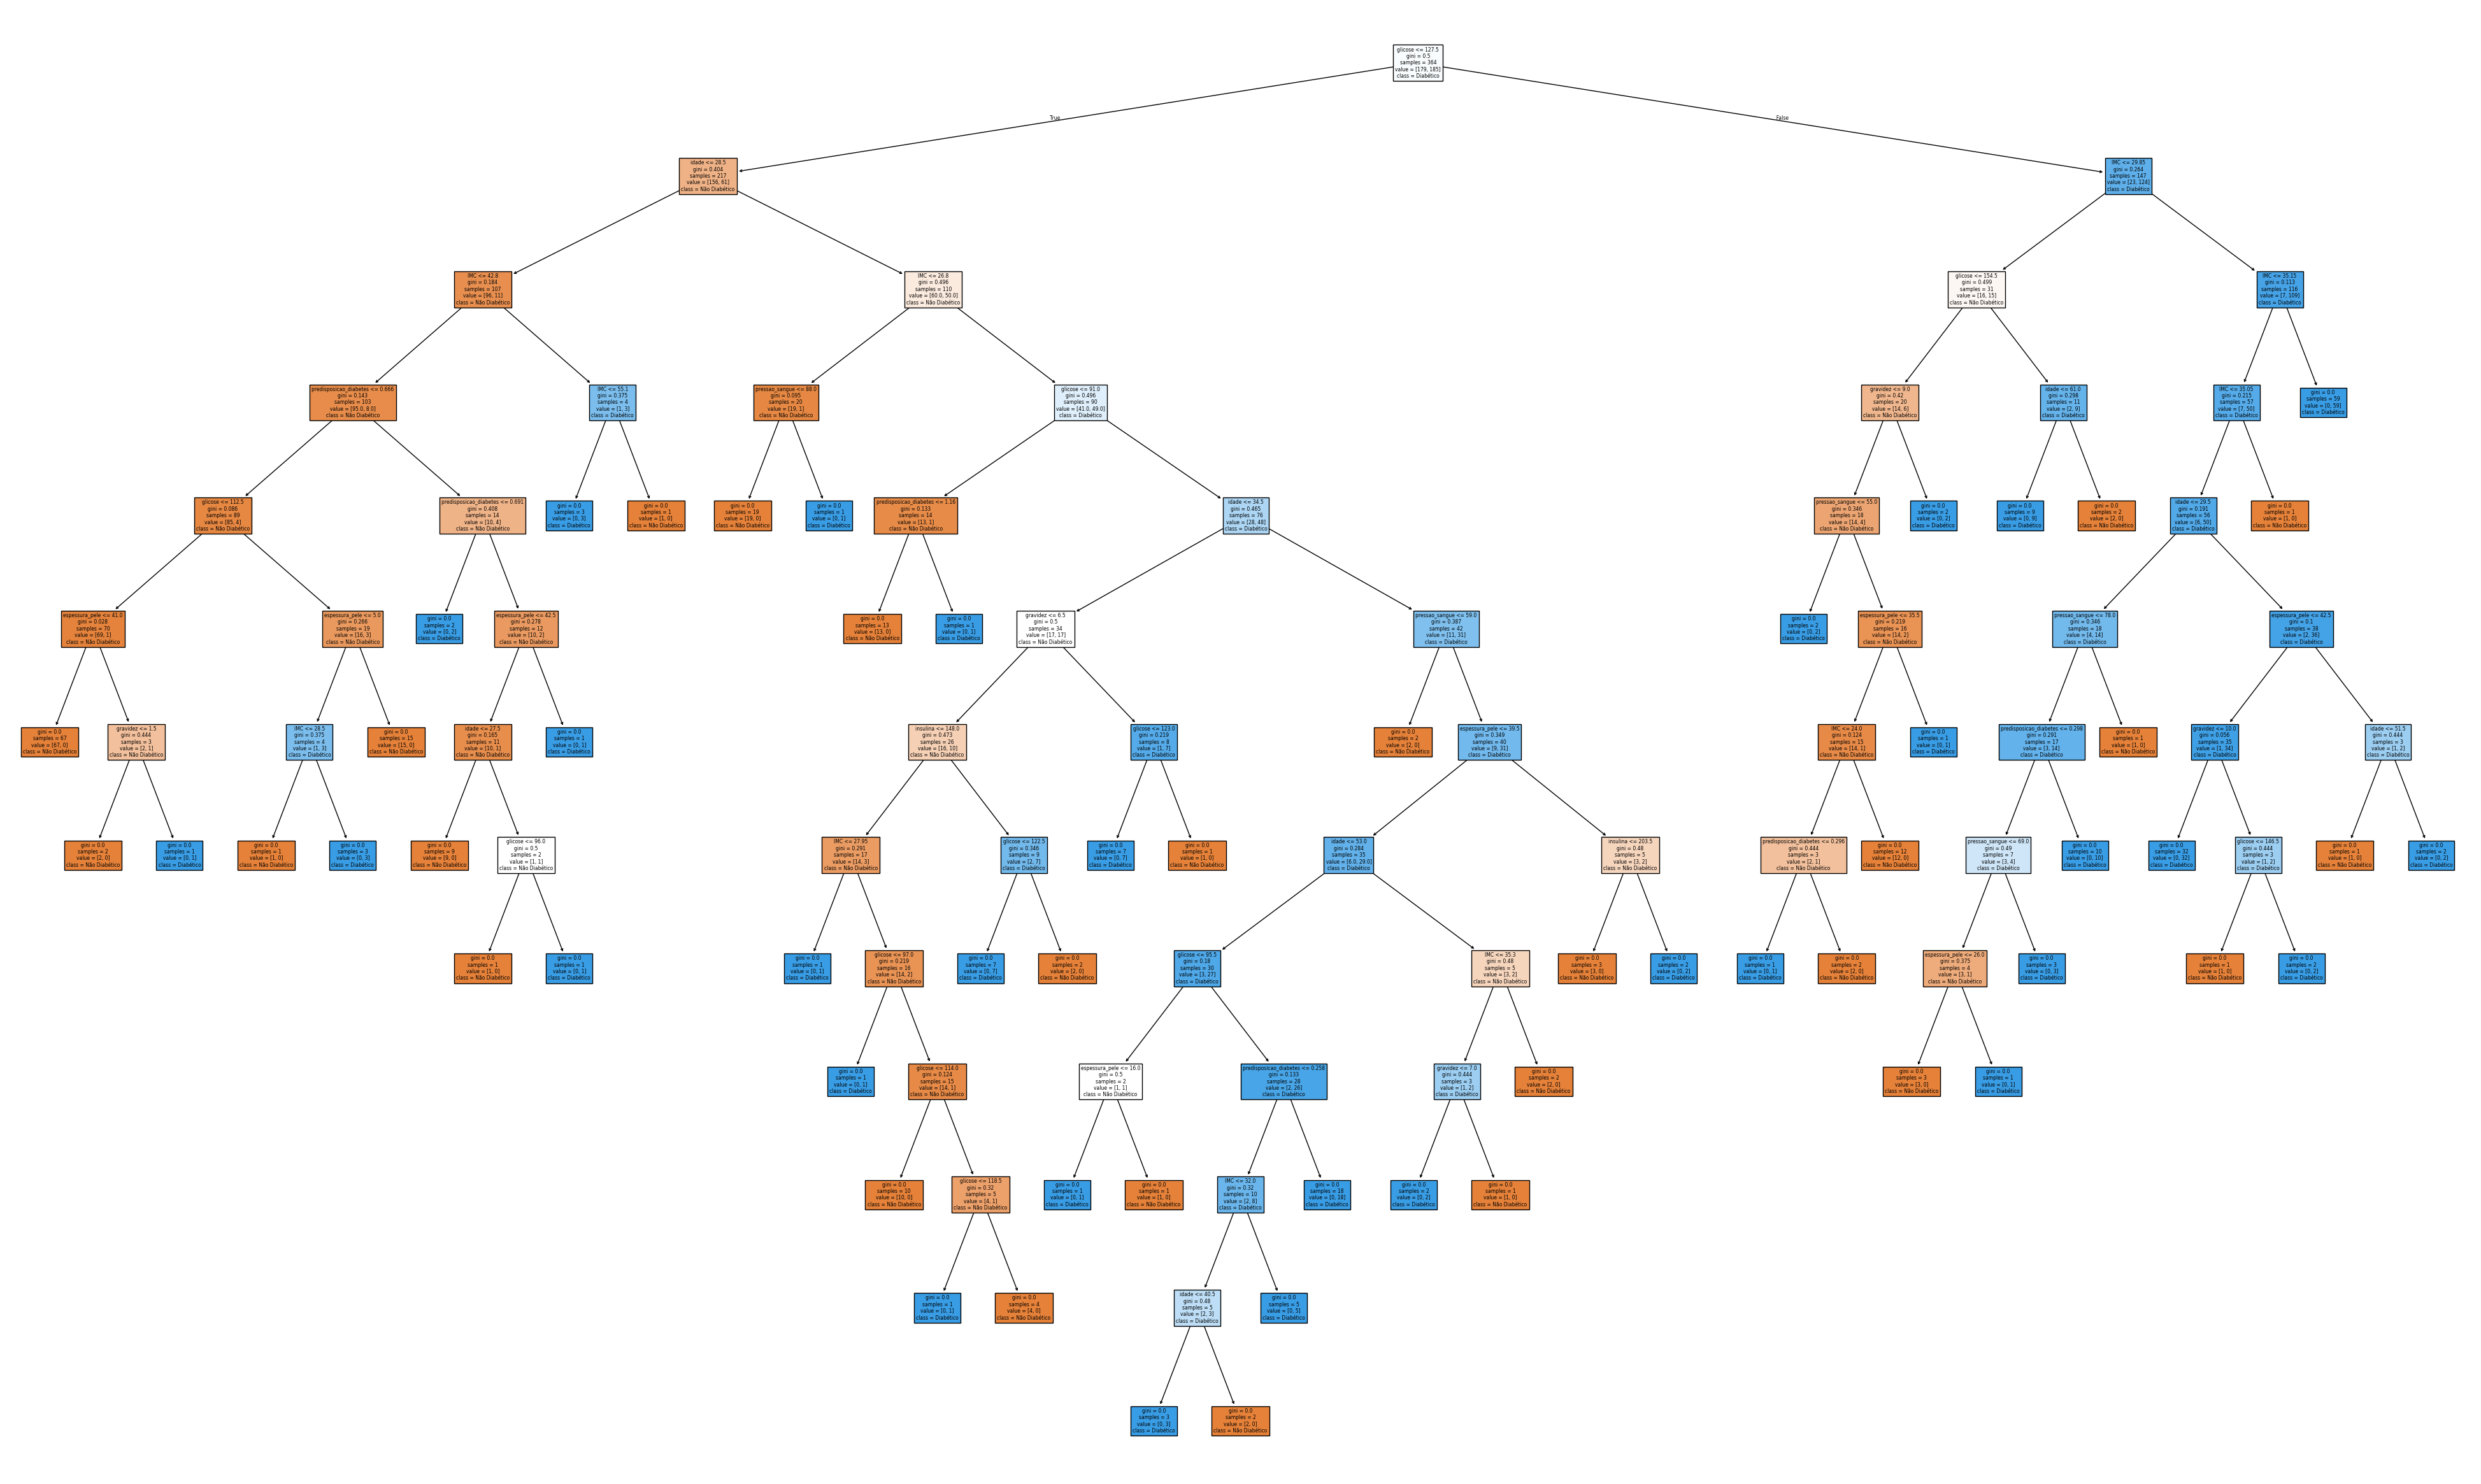

In [46]:
#@title Visualizando árvore de decisâo
import matplotlib.pyplot as plt
nome_features = df_diabetes.columns
nome_classes = ['Não Diabético', 'Diabético']
fig = plt.figure(figsize=(50,30))
tree.plot_tree(modelo,
                   feature_names=nome_features,
                   class_names=nome_classes,
                   filled=True)
plt.show()

In [47]:
#@title Verificando a acurácia do modelo
from sklearn.metrics import accuracy_score
accuracy_score(y_teste, y_predito)

0.7282608695652174

# Random Florest

In [48]:
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(random_state=42)
modelo_random_florest = classifier.fit(X_treino, y_treino)
y_pred = modelo_random_florest.predict(X_teste)

In [49]:
#@title Importância da features
pd.DataFrame(modelo_random_florest.feature_importances_, index=df_diabetes.columns[:-1], columns=['importancia']).sort_values(by='importancia', ascending=False)

,importancia
glicose,0.328321
IMC,0.156818
idade,0.140994
predisposicao_diabetes,0.104080
gravidez,0.080038
pressao_sangue,0.074558
insulina,0.059152
espessura_pele,0.056039


In [51]:
#@title Calculando a acurácia
accuracy_score(y_teste, y_pred)

0.8043478260869565

In [52]:
#@title Análise dos Resultados com Uso de Algoritmo Balanceado
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score


# Analise dos Resultados com Uso de Algoritmo Balanceado

In [53]:
#@title Criando Matriz de confusão
cm = confusion_matrix(y_teste, y_pred)

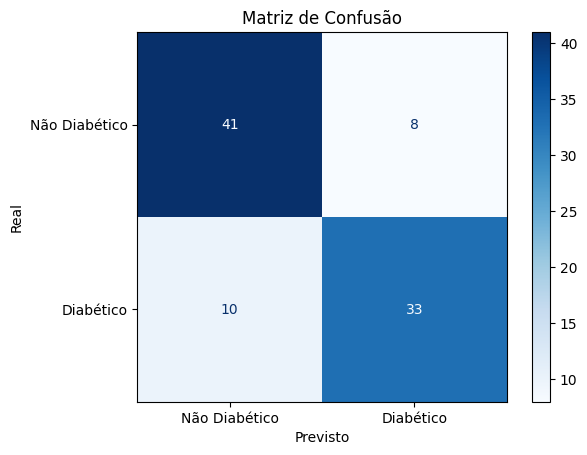

In [54]:
#@title Visualizando a matriz de confusão
labels=['Não Diabético', 'Diabético']
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues)
plt.xlabel('Previsto')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

In [55]:
#@title Calculando métrica de avaliação do modelo
#gerar relatório de classificação
report = classification_report(y_teste, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.80      0.84      0.82        49
           1       0.80      0.77      0.79        43

    accuracy                           0.80        92
   macro avg       0.80      0.80      0.80        92
weighted avg       0.80      0.80      0.80        92



# Avaliação dos Resultados Utilizando Algoritmo sem Balanceamento

In [56]:
#separar entre dados de treino e teste não balanceados
def nao_balancear_dados(X_dados, y_dados):
  X_train, X_test, y_train, y_test = train_test_split(X_dados, y_dados, test_size=0.2, random_state=42)
  return X_train, X_test, y_train, y_test

In [57]:
#@title Fazendo a separação de dados de treino e teste sem balanceamento
X_dados_nao_balanceado_treino, X_dados_nao_balanceado_teste, y_dados_nao_balanceado_treino, y_dados_nao_balanceado_teste = nao_balancear_dados(X_dados, y_dados)

In [58]:
#@title Criando o modelo com dados não balanceados
classifier_not_balenced = RandomForestClassifier(random_state=42)
modelo_random_florest_nao_balanceadi = classifier.fit(X_dados_nao_balanceado_treino, y_dados_nao_balanceado_treino)
y_pred_nao_balanceado = modelo_random_florest_nao_balanceadi.predict(X_dados_nao_balanceado_teste)

In [59]:
pd.DataFrame(modelo_random_florest_nao_balanceadi.feature_importances_, index=df_diabetes.columns[:-1], columns=['importancia']).sort_values(by='importancia', ascending=False)

,importancia
glicose,0.258864
IMC,0.169984
idade,0.140931
predisposicao_diabetes,0.123768
pressao_sangue,0.088134
gravidez,0.076551
insulina,0.076122
espessura_pele,0.065646


In [60]:
#@title Calculando acurácia do modelo não balanceado
acuracia_nao_balanceado = accuracy_score(y_dados_nao_balanceado_teste, y_pred_nao_balanceado)
acuracia_nao_balanceado

0.7207792207792207

In [61]:
#@title Criando a matriz de confusão
cm_nao_balanceado = confusion_matrix(y_dados_nao_balanceado_teste, y_pred_nao_balanceado)
cm_nao_balanceado

array([[77, 22],
       [21, 34]])

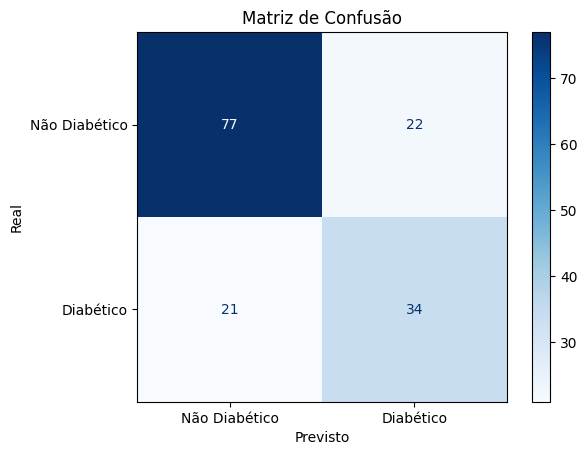

In [62]:
#@title Visualizando a matriz de confusâo
labels=['Não Diabético', 'Diabético']
disp = ConfusionMatrixDisplay(confusion_matrix=cm_nao_balanceado, display_labels=labels)
disp.plot(cmap=plt.cm.Blues)
plt.xlabel('Previsto')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

In [63]:
#@title Calculando métricas de avaliação do modelo
report_nao_balanceado = classification_report(y_dados_nao_balanceado_teste, y_pred_nao_balanceado)
print(report_nao_balanceado)
#

              precision    recall  f1-score   support

           0       0.79      0.78      0.78        99
           1       0.61      0.62      0.61        55

    accuracy                           0.72       154
   macro avg       0.70      0.70      0.70       154
weighted avg       0.72      0.72      0.72       154

